In [1]:
import os
import tensorflow as tf

2023-09-22 20:09:26.106666: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
import time
import functools

In [3]:
#downloading images (content image and style image)
#utils.get_file ---- gives url of the output
from tensorflow.keras import utils
content_path = utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
style_path

'/home/gowri/.keras/datasets/kandinsky5.jpg'

In [5]:
from tensorflow import image

In [6]:
#function to load image and limiting the maximum dimension of the image
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img) #This operation returns a tensor with the entire contents of the input filename. It does not do any parsing, it just returns the contents as they are. Usually, this is the first step in the input pipeline.
    img = tf.io.decode_image(img, channels=3, dtype = tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)
    img = tf.image.resize(img, new_shape) #resizing the shape such that dimension is limited to 512
    img = img[tf.newaxis, :]
    
    return img

In [9]:
image_sample_1 = load_img('/home/gowri/Desktop/projects/nst/image.jpeg')

In [10]:
image_sample_1

<tf.Tensor: shape=(1, 511, 236, 3), dtype=float32, numpy=
array([[[[0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9725491 , 0.9686275 , 0.9921569 ],
         ...,
         [0.86698395, 0.8304435 , 0.83436507],
         [0.90002114, 0.864727  , 0.8764917 ],
         [0.96924996, 0.93395585, 0.94572055]],

        [[0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9725491 , 0.9686275 , 0.9921569 ],
         ...,
         [0.8602509 , 0.82371044, 0.827632  ],
         [0.9538498 , 0.9185557 , 0.9303204 ],
         [0.9222291 , 0.886935  , 0.8986997 ]],

        [[0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9725491 , 0.9686275 , 0.9921569 ],
         [0.9729515 , 0.9690299 , 0.9925593 ],
         ...,
         [0.7738575 , 0.737317  , 0.7412386 ],
         [0.8675814 , 0.8322873 , 0.844052  ],
         [0.87255275, 0.83725864, 0.84902334]],

        ...,

        [[0.70166576, 0.6467638 , 

In [11]:
#function to display the image
def show_img(image, title = None):
    if(len(image.shape))>3:
        image = tf.squeeze(image, axis = 0) #if number of channels is more than 3 it squeezes the channels 
        
    plt.imshow(image)
    if title:
        plt.title(title)

In [12]:
#A function to convert a tensor to image
def tensor_to_image(tensor):
    tensor = tensor * 255 #denormalizing the tensor for grey scale
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    return PIL.Image.fromarray(tensor)

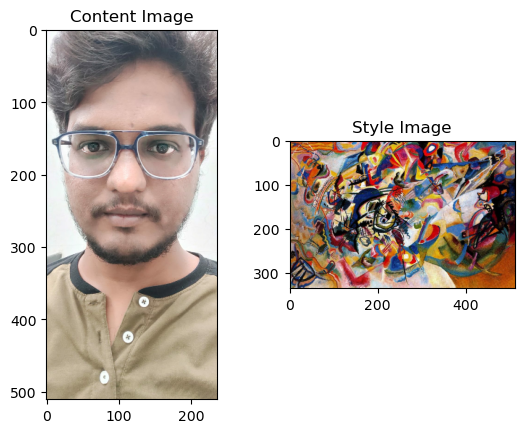

In [15]:
#content_image = load_img(content_path) 
content_image= load_img('/home/gowri/Desktop/projects/nst/image.jpeg')
style_image = load_img(style_path)

plt.subplot(1,2,1)
show_img(content_image, 'Content Image')
#show_img(image_sample_1,'Content Image')

plt.subplot(1,2,2)
show_img(style_image, 'Style Image')

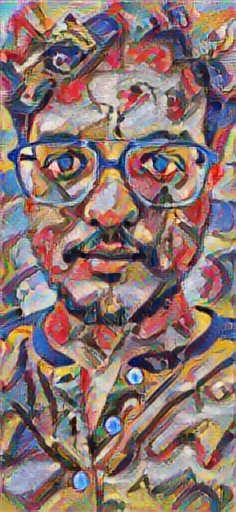

In [16]:
#Using TF-Hub repository
import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [17]:
!pip install tensorflow_hub

In [18]:
#Now building the NST model from VGG19
#Load VGG19
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x= tf.image.resize(x,(224, 224))


In [19]:
#Loading model and testing it on the given image
vgg = tf.keras.applications.VGG19(include_top = True, weights = 'imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape


TensorShape([1, 1000])

In [20]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('military_uniform', 0.09347754),
 ('sweatshirt', 0.05504768),
 ('Band_Aid', 0.0406943),
 ('sunglasses', 0.03391978),
 ('loupe', 0.028647887)]

In [21]:
# the above two cells are to verify the model vgg19 how it is working


In [22]:
#load vgg19 without the classification head and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [23]:
#Now choose intermediate layers from the network to represent the style and content of the image
#choosing block5_conv2 for content and conv1 of all 5 blocks for style layer 

#Question: why style needs more feature maps where as content needs only one feature map

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']


In [24]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [25]:
#function to return the list of intermediate layer outputs for VGG19 model

def vgg_layers_output(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    
    model = tf.keras.Model([vgg.input], outputs)
    return model


In [26]:
style_extractor = vgg_layers_output(style_layers) # gives the list of outputs of style layers taken
style_outputs = style_extractor(style_image*255)

for name,output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525
block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8853
  mean:  199.82687
block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78099
block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.143
  mean:  791.24005
block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179485


In [27]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [28]:
#Build a model that returns the style and content tensors.
class ContentStyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(ContentStyleModel, self).__init__()
       
        self.vgg = vgg_layers_output(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
        
    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

    
    #This function returns the content layer outputs and style layer outputs(after calculating the gram matrix)
    #we need to use this values and calculate the content loss and style loss to combine both of them
    
    

In [29]:
#calling the model
extractor = ContentStyleModel(style_layers, content_layers)
results = extractor.call(tf.constant(content_image))

In [30]:
print(type(results))

<class 'dict'>


In [31]:
print('Styles: ')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("  shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()
print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())



Styles: 
   block1_conv1
  shape:  (1, 64, 64)
    min:  0.006686107
    max:  41974.184
    mean:  269.2806

   block2_conv1
  shape:  (1, 128, 128)
    min:  0.0
    max:  51445.492
    mean:  9399.25

   block3_conv1
  shape:  (1, 256, 256)
    min:  0.0
    max:  333907.78
    mean:  10296.731

   block4_conv1
  shape:  (1, 512, 512)
    min:  10.192131
    max:  2547330.8
    mean:  173715.28

   block5_conv1
  shape:  (1, 512, 512)
    min:  0.0
    max:  294187.53
    mean:  1832.6534

Contents:
   block5_conv2
    shape:  (1, 31, 14, 512)
    min:  0.0
    max:  1219.621
    mean:  17.395004


In [32]:
# for the given input image these are the outputs at particular selected layers (note that at style they are gram matrices not exact matrices)

In [33]:
# Designing Style transfer algorithm

# finding errors for style and content by setting target values

style_targets = extractor.call(tf.constant(style_image))['style']
content_targets = extractor.call(tf.constant(content_image))['content']

In [34]:
print(type(style_targets))

<class 'dict'>


In [35]:
print(style_targets.keys())

dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [36]:
#initialized through content image we can even start with style image of random image
image = tf.Variable(content_image)

In [37]:
print(type(image))

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


In [38]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

In [39]:
#set the optimizer to adam
opt = tf.keras.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

In [40]:
style_weight = 1
content_weight = 1 #play with these values

In [41]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    style_loss *= style_weight/ num_style_layers
    content_loss *= content_weight/num_content_layers
    loss = style_loss + content_loss 
    return loss

In [42]:
#doing gradient for updates
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

step:  1
step:  2
step:  3
step:  4
step:  5
step:  6
step:  7
step:  8
step:  9
step:  10


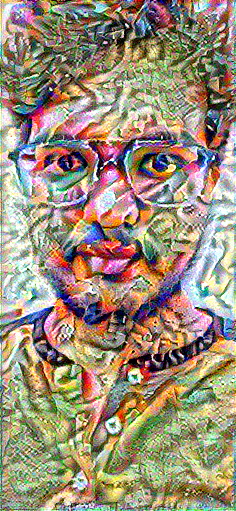

step:  11
step:  12
step:  13
step:  14
step:  15
step:  16
step:  17
step:  18
step:  19
step:  20


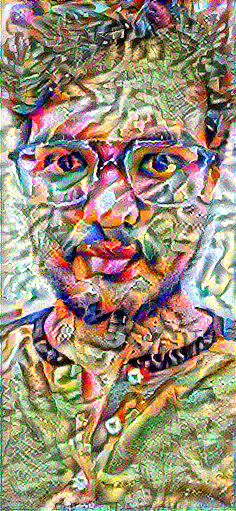

step:  21
step:  22
step:  23
step:  24
step:  25
step:  26
step:  27
step:  28
step:  29
step:  30


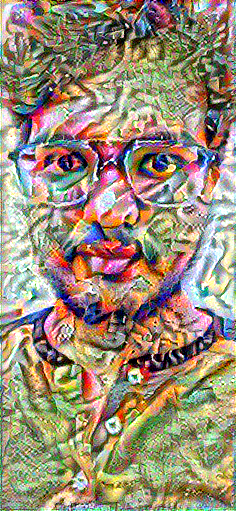

step:  31
step:  32
step:  33
step:  34
step:  35
step:  36
step:  37
step:  38
step:  39
step:  40


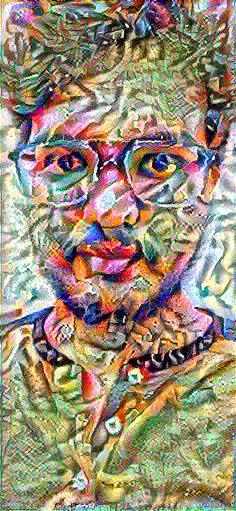

step:  41
step:  42
step:  43
step:  44
step:  45
step:  46
step:  47
step:  48
step:  49
step:  50


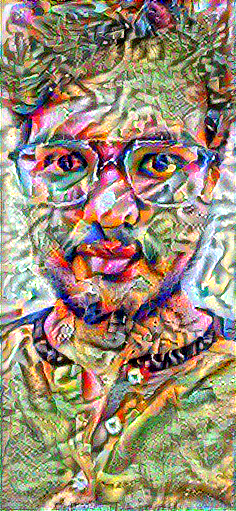

step:  51
step:  52
step:  53
step:  54
step:  55
step:  56
step:  57
step:  58
step:  59
step:  60


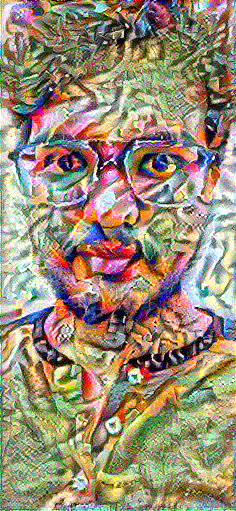

step:  61
step:  62
step:  63
step:  64
step:  65
step:  66
step:  67
step:  68
step:  69
step:  70


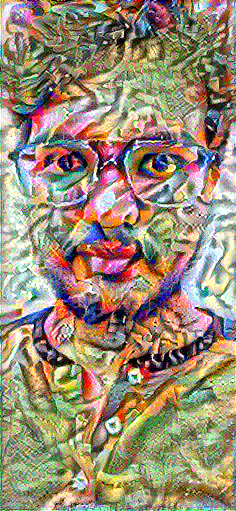

step:  71
step:  72
step:  73
step:  74
step:  75
step:  76
step:  77
step:  78
step:  79
step:  80


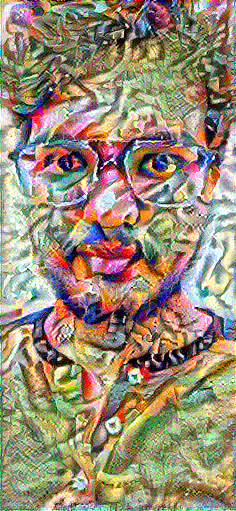

step:  81
step:  82
step:  83
step:  84
step:  85
step:  86
step:  87
step:  88
step:  89
step:  90


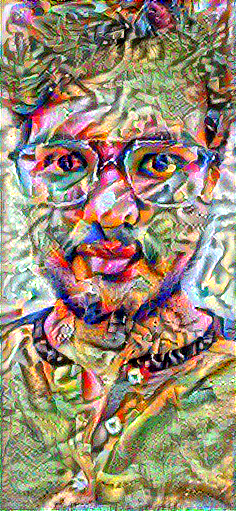

step:  91
step:  92
step:  93
step:  94
step:  95
step:  96
step:  97
step:  98
step:  99
step:  100


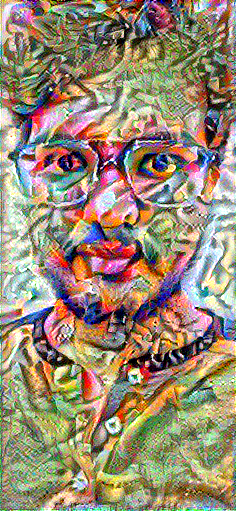

Total time: 83.7


In [45]:
#Running for n steps
import time
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step+=1
        train_step(image)  #
        print('step: ', step)
    display.display(tensor_to_image(image))
    
end = time.time()
print('Total time: {:.1f}' .format(end-start))

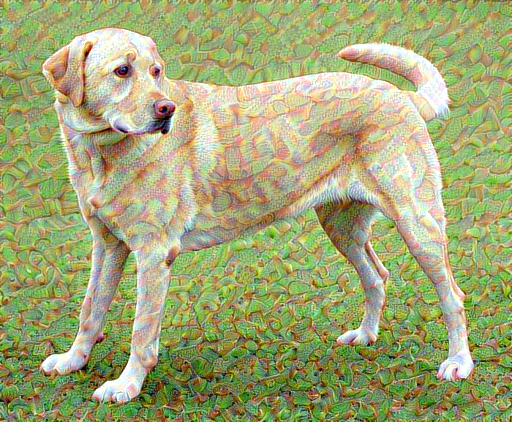